### 3-Layer Recursive Summarization

In [ ]:
import os
import openai
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import json

# === CONFIGURATION ===
openai.api_key = os.getenv("OPENAI_API_KEY")  # Or set manually: openai.api_key = 'sk-...'
DATA_PATH = "summaries.csv"                  # CSV file with a 'summary' column
INTERMEDIATE_DIR = Path("summarization_outputs")
INTERMEDIATE_DIR.mkdir(exist_ok=True)
MODEL = "gpt-4o"  # or use gpt-3.5-turbo for early layers if preferred
CHUNK_SIZE = 12000  # chars per chunk for summarizing
SUMMARIES_PER_SECONDARY = 20  # Group these into higher-level thematic summaries

# === STEP 1: LOAD DATA ===
df = pd.read_csv(DATA_PATH)
summaries = df['summary'].dropna().tolist()

# === STEP 2: CHUNK INTO ROUGHLY CHUNK_SIZE GROUPS ===
def chunk_summaries(summary_list, max_chars=CHUNK_SIZE):
    chunks = []
    current_chunk = ""
    for summary in summary_list:
        if len(current_chunk) + len(summary) <= max_chars:
            current_chunk += "\n\n" + summary
        else:
            chunks.append(current_chunk.strip())
            current_chunk = summary
    if current_chunk:
        chunks.append(current_chunk.strip())
    return chunks

primary_chunks = chunk_summaries(summaries)
print(f"✅ Level 1: {len(primary_chunks)} primary chunks to summarize.")

# === STEP 3: SUMMARIZE EACH PRIMARY CHUNK ===
GENIE_PROMPT = """You are an assistant specializing in summarizing scientific papers. For each text, answer the following questions with regards to the American Association for Cancer Research's Project GENIE:

1. Research Applications: What are the most common research areas or fields utilizing the GENIE dataset?
2. Dataset Integration: How frequently is GENIE used in combination with other datasets, and which ones are most common?
3. Novel Insights: What novel biological, clinical, or methodological insights have been gained by studies leveraging GENIE data?
4. Emerging Trends: Are there any emerging trends in how researchers are applying GENIE data?
5. Frequently Used Features: What specific data elements or features from GENIE are most frequently cited or utilized in publications?
6. Systematic Biases: Have researchers identified any systematic biases or limitations in the GENIE dataset, including regional or demographic representativeness?
7. Data Quality and Preprocessing: How do researchers address potential data quality issues, missing information, or preprocessing challenges in GENIE?
8. Validation and Replicability: How is the GENIE dataset validated within studies, and are there challenges with replicability of findings?
9. Analytical Methods: What are the most common analytical methods, algorithms, or innovative approaches applied to GENIE data?
10. Comparative Analysis: How does GENIE compare to other similar datasets in terms of utility, comprehensiveness, and limitations?
11. Integration with Technologies: How are researchers integrating AI, machine learning, or other computational tools with GENIE data?
12. Clinical Impact: How has research using GENIE data contributed to clinical advancements or influenced oncology guidelines?
13. Dataset Evolution: How has the usage of GENIE data evolved over time in response to dataset updates or expansions?
14. Future Directions: What areas for future research are suggested in the studies, and how might GENIE data support or hinder these?
15. Dataset Improvement: What specific suggestions do researchers provide for expanding or enhancing the GENIE dataset, including data types, features, or global representativeness?
"""

def summarize_text(text, prompt=GENIE_PROMPT, model=MODEL, max_tokens=1500):
    response = openai.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": prompt},
            {"role": "user", "content": text}
        ],
        temperature=0.4,
        max_tokens=max_tokens
    )
    return response.choices[0].message.content.strip()

# L1 summaries (save to file so you can restart if interrupted)
L1_OUTPUT_PATH = INTERMEDIATE_DIR / "level1_summaries.json"
if L1_OUTPUT_PATH.exists():
    with open(L1_OUTPUT_PATH, "r") as f:
        level1_summaries = json.load(f)
else:
    level1_summaries = []
    for chunk in tqdm(primary_chunks, desc="Level 1 Summaries"):
        summary = summarize_text(chunk)
        level1_summaries.append(summary)
    with open(L1_OUTPUT_PATH, "w") as f:
        json.dump(level1_summaries, f, indent=2)

print(f"✅ Level 1 complete. {len(level1_summaries)} intermediate summaries generated.")

# === STEP 4: GROUP INTO SECONDARY CHUNKS ===
def group_summaries(summaries, per_group=SUMMARIES_PER_SECONDARY):
    return [
        "\n\n".join(summaries[i:i+per_group])
        for i in range(0, len(summaries), per_group)
    ]

secondary_chunks = group_summaries(level1_summaries)
print(f"✅ Level 2: {len(secondary_chunks)} thematic chunks to summarize.")

# L2 summaries
L2_OUTPUT_PATH = INTERMEDIATE_DIR / "level2_summaries.json"
if L2_OUTPUT_PATH.exists():
    with open(L2_OUTPUT_PATH, "r") as f:
        level2_summaries = json.load(f)
else:
    level2_summaries = []
    for chunk in tqdm(secondary_chunks, desc="Level 2 Summaries"):
        summary = summarize_text(chunk)
        level2_summaries.append(summary)
    with open(L2_OUTPUT_PATH, "w") as f:
        json.dump(level2_summaries, f, indent=2)

# === STEP 5: FINAL SYNTHESIS ===
print("🧠 Generating final 3–5 paragraph summary...")

FINAL_PROMPT = (
    "You are an assistant who has reviewed many studies using Project GENIE. "
    "Write a 3–5 paragraph comprehensive synthesis of the following thematic summaries:"
)

final_input = "\n\n".join(level2_summaries)
final_summary = summarize_text(final_input, prompt=FINAL_PROMPT, max_tokens=1500)

with open(INTERMEDIATE_DIR / "final_summary.txt", "w") as f:
    f.write(final_summary)

print("✅ Final Summary:\n")
print(final_summary)

![ChatGPT Image Apr 3, 2025, 01_38_26 PM.png](<attachment:ChatGPT Image Apr 3, 2025, 01_38_26 PM.png>)
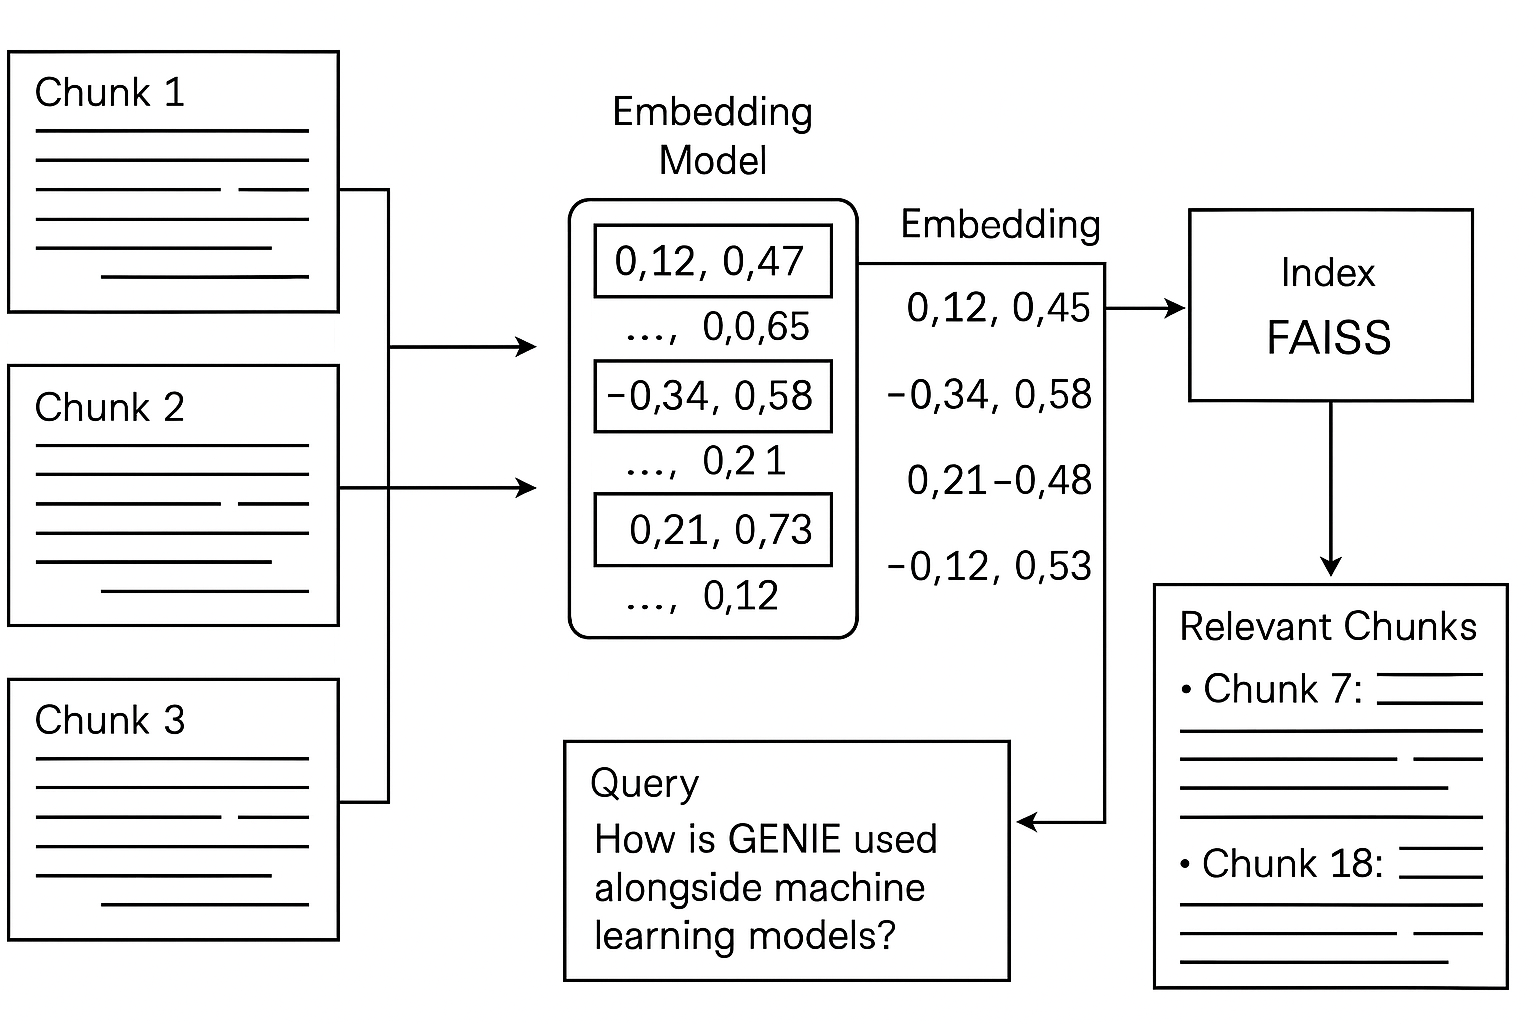

### Create embeddings

In [ ]:
#create embeddings
import openai
import pandas as pd
import numpy as np
import faiss
from tqdm import tqdm

# --- CONFIG ---
openai.api_key = 'your-api-key'  # Or use environment variables
embedding_model = 'text-embedding-3-large' #might need to check if available--'text-embedding-3-small' is good enough if not but large is best

# --- Load or assume df_chunks exists ---
# Columns: titles, chunk_id, chunk_text

# --- Generate embeddings ---
embeddings = []
metadata = []

for row in tqdm(df_chunks.itertuples(), total=len(df_chunks)):
    try:
        response = openai.Embedding.create(
            model=embedding_model,
            input=row.chunk_text
        )
        vector = response['data'][0]['embedding']
        embeddings.append(vector)
        metadata.append({
            "chunk_id": row.chunk_id,
            "titles": row.titles
        })
    except Exception as e:
        print(f"Error on chunk_id {row.chunk_id}: {e}")
        continue

# --- Convert to numpy array ---
embedding_matrix = np.array(embeddings).astype('float32')

# --- Create FAISS index ---
dimension = len(embedding_matrix[0])
index = faiss.IndexFlatL2(dimension)
index.add(embedding_matrix)

# --- Save index and metadata ---
#faiss.write_index(index, "chunk_embeddings.index")
#pd.DataFrame(metadata).to_json("chunk_metadata.jsonl", orient="records", lines=True)

###################project_path = path to google drive folder

# Save FAISS index to Google Drive
faiss.write_index(index, os.path.join(project_path, "chunk_embeddings.index"))

# Save metadata to Google Drive
pd.DataFrame(metadata).to_json(os.path.join(project_path, "chunk_metadata.jsonl"), orient="records", lines=True)

### Retrieval

In [ ]:
# Load FAISS index from Google Drive
index = faiss.read_index(os.path.join(project_path, "chunk_embeddings.index"))

# Load metadata from Google Drive
import json
with open(os.path.join(project_path, "chunk_metadata.jsonl"), "r") as f:
    metadata = [json.loads(line) for line in f]

# Step 1: Embed the query
query = "How do CD8+ T cells interact with the tumor microenvironment?"
query_embedding = openai.Embedding.create(
    model=embedding_model,
    input=query
)['data'][0]['embedding']

# Step 2: Search FAISS
k = 5  # Top 5 results
D, I = index.search(np.array([query_embedding]).astype('float32'), k)

# Step 3: Retrieve metadata
top_chunks = [metadata[i] for i in I[0]]
print(top_chunks)

### ?

In [ ]:
# Create a Colab-friendly notebook with a recursive summarization pipeline using gpt-4o-mini
notebook_code = """
# 📘 Recursive Summarization of GENIE Dataset Research Summaries
# --------------------------------------------------------------
# Goal: Summarize a large collection of summaries related to Project GENIE using a structured scientific prompt.
# Model: gpt-4o-mini (via OpenAI API)
# Note: Designed to run in Google Colab

# 🛠️ Install dependencies
!pip install openai pandas tiktoken --quiet

# 📦 Import libraries
import openai
import pandas as pd
from tqdm import tqdm
from google.colab import drive

# 🔐 Set your OpenAI API key
openai.api_key = 'your-openai-api-key'  # <-- Replace this with your key

# 📂 Mount Google Drive
drive.mount('/content/drive')

# 📄 Load your dataset (adjust the path as needed)
df = pd.read_pickle('/content/drive/MyDrive/your_folder/embedded_chunks.pkl')  # or .csv
df = df[df['summary'].notnull()]

# 🧱 Chunk the summaries into batches (~10k characters)
def chunk_summaries(summary_list, max_chars=10000):
    chunks = []
    current_chunk = ""
    for summary in summary_list:
        if len(current_chunk) + len(summary) <= max_chars:
            current_chunk += " " + summary
        else:
            chunks.append(current_chunk.strip())
            current_chunk = summary
    if current_chunk:
        chunks.append(current_chunk.strip())
    return chunks

all_summaries = df['summary'].tolist()
summary_chunks = chunk_summaries(all_summaries, max_chars=10000)

# 🧠 Define the GENIE-specific summarization prompt
genie_prompt = \"\"\"
You are an assistant specializing in summarizing scientific papers. For each text, answer the following questions with regards to the American Association for Cancer Research's Project GENIE:

1. Research Applications: What are the most common research areas or fields utilizing the GENIE dataset?
2. Dataset Integration: How frequently is GENIE used in combination with other datasets, and which ones are most common?
3. Novel Insights: What novel biological, clinical, or methodological insights have been gained by studies leveraging GENIE data?
4. Emerging Trends: Are there any emerging trends in how researchers are applying GENIE data?
5. Frequently Used Features: What specific data elements or features from GENIE are most frequently cited or utilized in publications?
6. Systematic Biases: Have researchers identified any systematic biases or limitations in the GENIE dataset, including regional or demographic representativeness?
7. Data Quality and Preprocessing: How do researchers address potential data quality issues, missing information, or preprocessing challenges in GENIE?
8. Validation and Replicability: How is the GENIE dataset validated within studies, and are there challenges with replicability of findings?
9. Analytical Methods: What are the most common analytical methods, algorithms, or innovative approaches applied to GENIE data?
10. Comparative Analysis: How does GENIE compare to other similar datasets in terms of utility, comprehensiveness, and limitations?
11. Integration with Technologies: How are researchers integrating AI, machine learning, or other computational tools with GENIE data?
12. Clinical Impact: How has research using GENIE data contributed to clinical advancements or influenced oncology guidelines?
13. Dataset Evolution: How has the usage of GENIE data evolved over time in response to dataset updates or expansions?
14. Future Directions: What areas for future research are suggested in the studies, and how might GENIE data support or hinder these?
15. Dataset Improvement: What specific suggestions do researchers provide for expanding or enhancing the GENIE dataset, including data types, features, or global representativeness?
\"\"\"

# ✨ Function to summarize a single chunk
def summarize_chunk(text, prompt):
    response = openai.chat.completions.create(
        model="gpt-4o",  # using 4o-mini here
        messages=[
            {"role": "system", "content": prompt},
            {"role": "user", "content": text}
        ],
        temperature=0.3,
        max_tokens=1500
    )
    return response.choices[0].message.content.strip()

# 🔁 Summarize each chunk
intermediate_summaries = [summarize_chunk(chunk, genie_prompt) for chunk in tqdm(summary_chunks)]

# 🧾 Optionally save intermediate summaries to Drive
pd.DataFrame({"chunk_summary": intermediate_summaries}).to_csv(
    "/content/drive/MyDrive/your_folder/intermediate_genie_summaries.csv", index=False
)

# 🧠 Final synthesis of all intermediate summaries
final_input = "\\n\\n".join(intermediate_summaries)
final_prompt = "You are an assistant who has read multiple analyses of research using the AACR Project GENIE dataset. Create a comprehensive, 3-5 paragraph synthesis of key findings based on the following detailed intermediate summaries:"

final_summary = summarize_chunk(final_input, final_prompt)

# 📋 Output final result
print("✅ Final Summary:\\n")
print(final_summary)

# 💾 Save final summary to file
with open("/content/drive/MyDrive/your_folder/final_genie_summary.txt", "w") as f:
    f.write(final_summary)
"""

# Save to file so user can open it in Colab
with open("/mnt/data/GENIE_Summary_Colab_Notebook.ipynb", "w") as f:
    f.write(notebook_code)

"/mnt/data/GENIE_Summary_Colab_Notebook.ipynb"



### Below is FAISS similarity search

In [ ]:
# Update the original notebook by appending FAISS integration and search_corpus helper
with open("/mnt/data/GENIE_Summary_Colab_Notebook.ipynb", "a") as f:
    faiss_code = """

# 🧠 -------------------------------------
# 🔎 FAISS Semantic Search Integration
# --------------------------------------

# 🛠️ Install FAISS
!pip install faiss-cpu --quiet

import faiss
import numpy as np
import pickle

# 🔄 Prepare embeddings for FAISS
embeddings = np.vstack(df['embedding'].tolist()).astype('float32')

# 📦 Create and save FAISS index
dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(embeddings)

faiss.write_index(index, "/content/drive/MyDrive/your_folder/genie_chunks.index")
with open("/content/drive/MyDrive/your_folder/genie_chunk_metadata.pkl", "wb") as f:
    pickle.dump(df[['chunk_id', 'chunk', 'file_names']], f)

# 🔍 Helper function for semantic search
def get_embedding(text, model="text-embedding-3-large"):
    response = openai.embeddings.create(input=text, model=model)
    return np.array(response.data[0].embedding, dtype='float32')

def search_corpus(query, top_k=5, summarize=False):
    # Load index and metadata
    index = faiss.read_index("/content/drive/MyDrive/your_folder/genie_chunks.index")
    with open("/content/drive/MyDrive/your_folder/genie_chunk_metadata.pkl", "rb") as f:
        metadata_df = pickle.load(f)

    # Embed query and search
    query_embedding = get_embedding(query).reshape(1, -1)
    D, I = index.search(query_embedding, k=top_k)
    results = metadata_df.iloc[I[0]]

    # Print results or summarize
    print(f"🔎 Top {top_k} Results for: '{query}'\\n")
    for i, row in results.iterrows():
        print(f"📄 Chunk ID: {row['chunk_id']} | File: {row['file_names']}")
        print(row['chunk'][:700] + "\\n---\\n")

    if summarize:
        combined = "\\n\\n".join(results['chunk'].tolist())
        summary_prompt = f"Summarize the following research excerpts with a focus on the query: '{query}'"
        response = openai.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": summary_prompt},
                {"role": "user", "content": combined}
            ],
            temperature=0.3,
            max_tokens=1500
        )
        print("🧠 Summary of Results:\\n")
        print(response.choices[0].message.content.strip())
"""
    f.write(faiss_code)

"/mnt/data/GENIE_Summary_Colab_Notebook.ipynb"

